<a href="https://colab.research.google.com/github/vasujain1970/StockPrice/blob/main/Stock_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [100]:
import pandas_datareader as pdr
key="7196e5f1e544b035d71c2f818bd81ce11b655d5e"
df = pdr.get_data_tiingo('MSFT', api_key=key)

In [101]:
df.head()

close    high  ...  divCash  splitFactor
symbol date                                      ...                      
MSFT   2016-08-08 00:00:00+00:00  58.06  58.085  ...      0.0          1.0
       2016-08-09 00:00:00+00:00  58.20  58.500  ...      0.0          1.0
       2016-08-10 00:00:00+00:00  58.02  58.320  ...      0.0          1.0
       2016-08-11 00:00:00+00:00  58.30  58.450  ...      0.0          1.0
       2016-08-12 00:00:00+00:00  57.94  58.190  ...      0.0          1.0

[5 rows x 12 columns]

In [102]:
from matplotlib import pyplot as plt
df.shape

(1257, 12)

In [103]:
df1 = df.reset_index()['close']
df1

0        58.06
1        58.20
2        58.02
3        58.30
4        57.94
         ...  
1252    286.50
1253    284.91
1254    284.82
1255    287.12
1256    286.51
Name: close, Length: 1257, dtype: float64

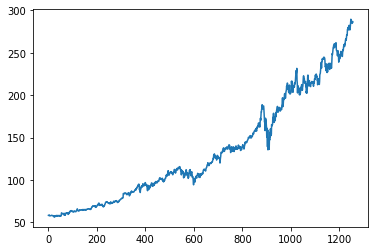

In [104]:
plt.plot(df1)

In [105]:
#LSTM is scale sensitive. Use minmax scaler to scale all the data between 0 and 1

In [106]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [107]:
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

In [108]:
#Create training and testing split, cannot be random as data is time sensitive
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [109]:
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		input = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(input)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [110]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [111]:
X_train.shape, y_train.shape

((716, 100), (716,))

In [112]:
X_test.shape

(339, 100)

In [113]:
# We need to reshape it for the LSTM model to work --> from 2D to 3D
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [114]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [115]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100,1)))
model.add(LSTM(50, return_sequences=True))
# model.add(LSTM(25,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [116]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 100, 50)           10400     
_________________________________________________________________
lstm_10 (LSTM)               (None, 100, 50)           20200     
_________________________________________________________________
lstm_11 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [117]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 5, batch_size = 32, verbose = 1)

Epoch 1/5
23/23 [==============================] - 10s 213ms/step - loss: 0.0071 - val_loss: 0.0016
Epoch 2/5
23/23 [==============================] - 4s 163ms/step - loss: 2.9411e-04 - val_loss: 0.0017
Epoch 3/5
23/23 [==============================] - 4s 161ms/step - loss: 1.5615e-04 - val_loss: 0.0026
Epoch 4/5
23/23 [==============================] - 4s 164ms/step - loss: 1.4691e-04 - val_loss: 0.0030
Epoch 5/5
23/23 [==============================] - 4s 163ms/step - loss: 1.5334e-04 - val_loss: 0.0045


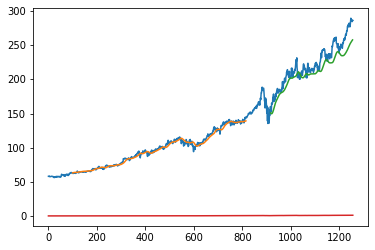

In [118]:
import tensorflow as tf
import numpy
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))
math.sqrt(mean_squared_error(y_test,test_predict))
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.plot(df1)
plt.show()

In [120]:
 from numpy import array
lst_output=[]
n_steps=4184
i=0
while(i<=30):
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

0 day input [7.33474062e-01 1.24654253e-06 1.29626218e-06 ... 1.45550159e-01
 0.00000000e+00 8.98940482e-09]
0 day output [[0.03048591]]
1 day input [1.24654253e-06 1.29626218e-06 1.19877616e-06 ... 0.00000000e+00
 8.98940482e-09 3.04859094e-02]
1 day output [[0.0308049]]
2 day input [1.29626218e-06 1.19877616e-06 1.22523411e-06 ... 8.98940482e-09
 3.04859094e-02 3.08049023e-02]
2 day output [[0.03110131]]
3 day input [1.19877616e-06 1.22523411e-06 7.33474062e-01 ... 3.04859094e-02
 3.08049023e-02 3.11013050e-02]
3 day output [[0.03138686]]
4 day input [1.22523411e-06 7.33474062e-01 0.00000000e+00 ... 3.08049023e-02
 3.11013050e-02 3.13868597e-02]
4 day output [[0.03167046]]
5 day input [7.33474062e-01 0.00000000e+00 8.98940482e-09 ... 3.11013050e-02
 3.13868597e-02 3.16704623e-02]
5 day output [[0.03195804]]
6 day input [0.00000000e+00 8.98940482e-09 1.28287796e-06 ... 3.13868597e-02
 3.16704623e-02 3.19580398e-02]
6 day output [[0.03225308]]
7 day input [8.98940482e-09 1.28287796e-06

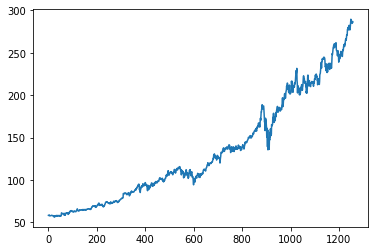

In [129]:
x_input=test_data[341:].reshape(1,-1)
x_input.shape
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
day_new=np.arange(1,1258)
day_pred=np.arange(1,32)
import matplotlib.pyplot as plt
plt.plot(day_new,scaler.inverse_transform(df1))


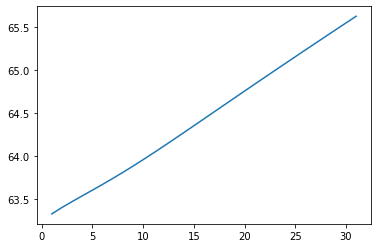

In [130]:
plt.plot(day_pred,scaler.inverse_transform(lst_output))
df3=df1.tolist()
df3.extend(lst_output)

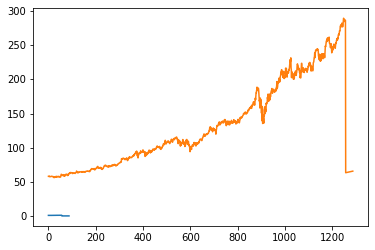

In [131]:
plt.plot(df3[1200:])
df3=scaler.inverse_transform(df3).tolist()
plt.plot(df3)